# Importing Library

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Data Information

In [3]:
def scrape_quotes():
    base_url = "https://quotes.toscrape.com"
    quotes = []
    authors = []
    tags = []

    for page in range(1, 10):  
        response = requests.get(f"{base_url}/page/{page}/")
        soup = BeautifulSoup(response.text, 'html.parser')

        for quote in soup.find_all('div', class_='quote'):
            quotes.append(quote.find('span', class_='text').text)
            authors.append(quote.find('small', class_='author').text)
            tags.append([tag.text for tag in quote.find_all('a', class_='tag')])

    return pd.DataFrame({'quote': quotes, 'author': authors, 'tags': tags})

In [4]:
df = scrape_quotes()

In [5]:
df.head()

,quote,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"[change, deep-thoughts, thinking, world]"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"[abilities, choices]"
2,“There are only two ways to live your life. On...,Albert Einstein,"[inspirational, life, live, miracle, miracles]"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"[aliteracy, books, classic, humor]"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"[be-yourself, inspirational]"


In [6]:
print("Total number of quote:", len(df))
print("Total number of authors:", df['author'].nunique())
print("Total number of tag:", len(set([tag for sublist in df['tags'] for tag in sublist])))

Total number of quote: 90
Total number of authors: 44
Total number of tag: 130


# Data Visualization

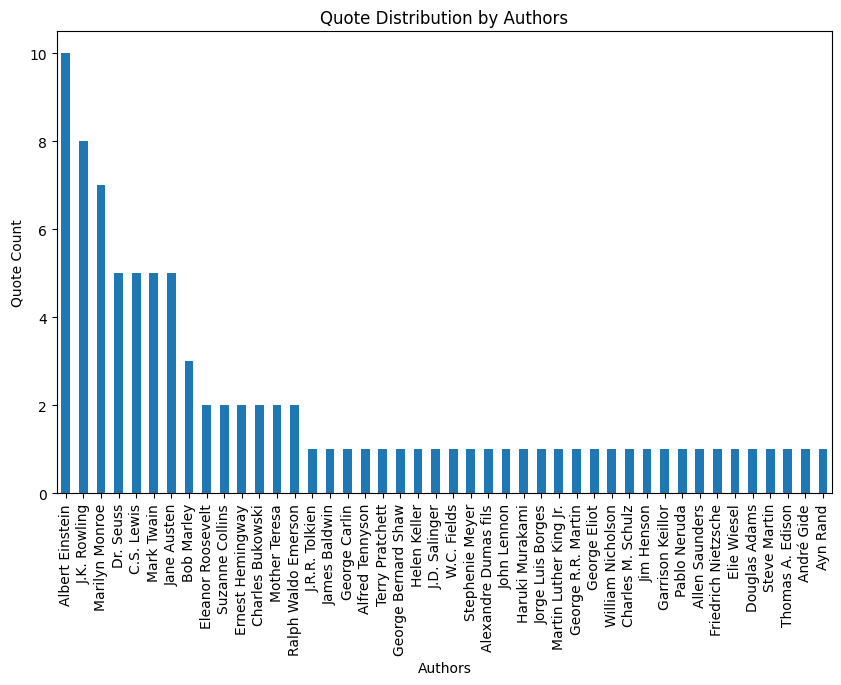

In [7]:
plt.figure(figsize=(10, 6))
df['author'].value_counts().plot(kind='bar')
plt.title('Quote Distribution by Authors')
plt.xlabel('Authors')
plt.ylabel('Quote Count')
plt.show()

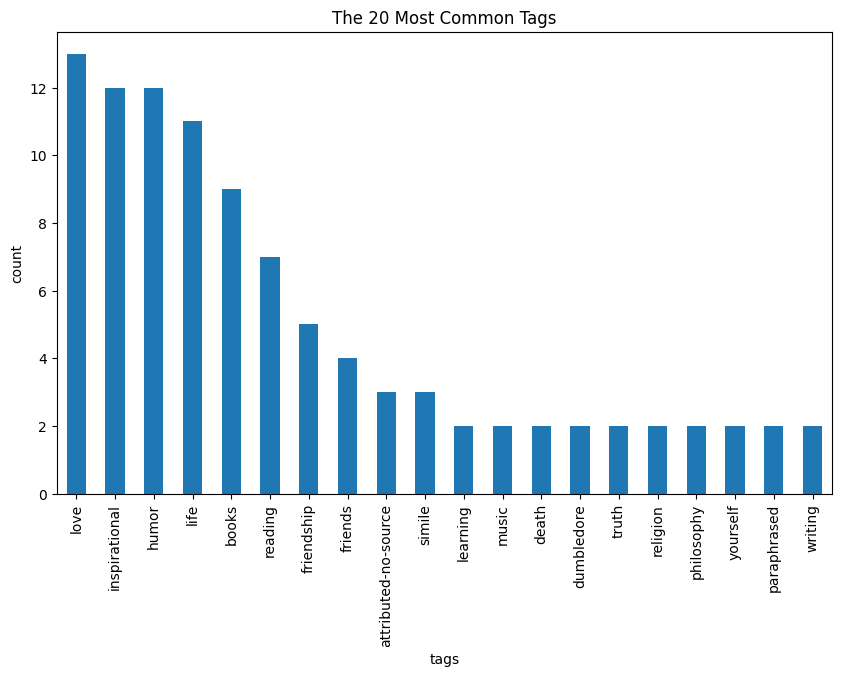

In [8]:
plt.figure(figsize=(10, 6))
all_tags = [tag for sublist in df['tags'] for tag in sublist]
pd.Series(all_tags).value_counts().head(20).plot(kind='bar')
plt.title('The 20 Most Common Tags')
plt.xlabel('tags')
plt.ylabel('count')
plt.show()

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['quote'])
y = df['tags'].apply(lambda x: x[0] if len(x) > 0 else 'unknown') 

In [10]:
print("Distribution of tags:")
print(y.value_counts().head(10))

Distribution of tags:
tags
humor                   10
books                    7
love                     5
friendship               4
inspirational            4
life                     4
unknown                  3
attributed-no-source     3
death                    2
music                    2
Name: count, dtype: int64


# Train Models

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel='linear')
}

# Evaluate Models

In [13]:
results = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1-Score", "Accuracy"])

In [14]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = (y_pred == y_test).mean()
    
    result = pd.DataFrame({
        "Model": [model_name],
        "Precision": [report["weighted avg"]["precision"]],
        "Recall": [report["weighted avg"]["recall"]],
        "F1-Score": [report["weighted avg"]["f1-score"]],
        "Accuracy": [accuracy]
    })
    
    results = pd.concat([results, result], ignore_index=True)

/var/folders/tf/pv5thw81757bd82bstp66x240000gn/T/ipykernel_3598/1594544687.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result], ignore_index=True)


In [15]:
print(results)

                    Model  Precision    Recall  F1-Score  Accuracy
0     Logistic Regression   0.003086  0.055556  0.005848  0.055556
1             Naive Bayes   0.003086  0.055556  0.005848  0.055556
2  Support Vector Machine   0.003086  0.055556  0.005848  0.055556


In [16]:
best_model_name = results.loc[results['F1-Score'].idxmax()]["Model"]
best_model = models[best_model_name]

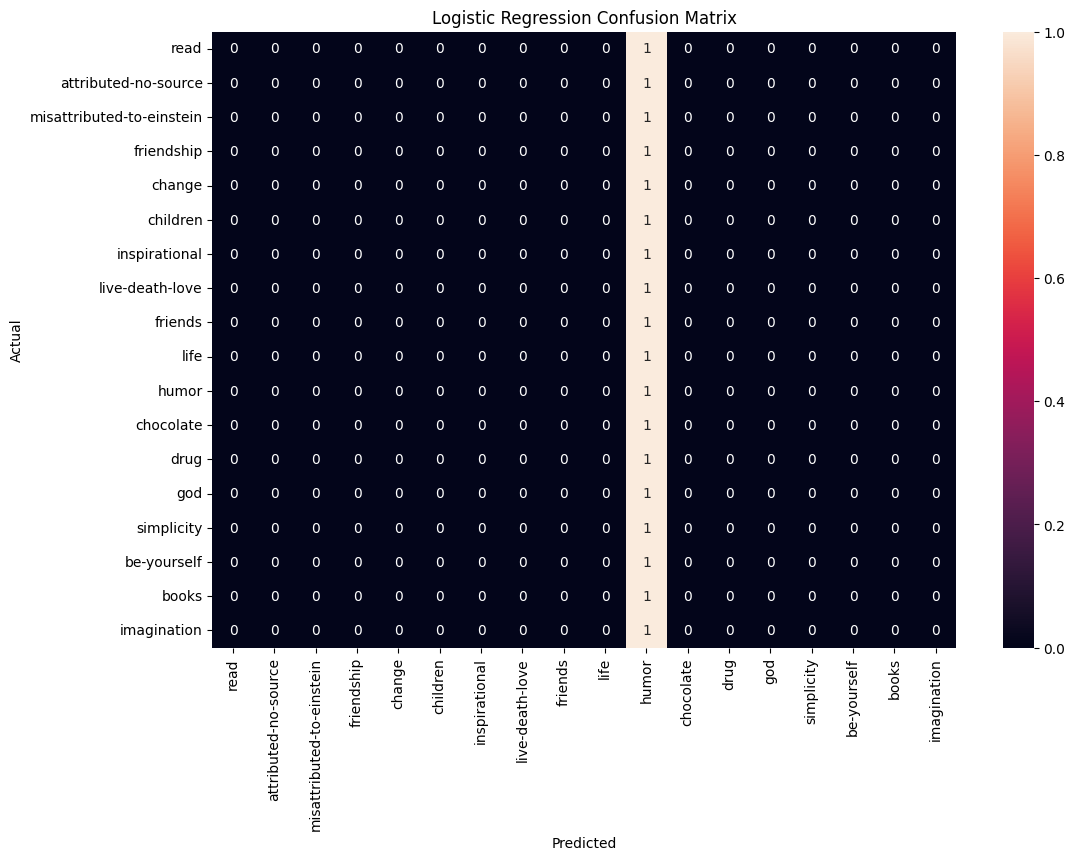

In [17]:
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=y_test.unique())
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.title(f'{best_model_name} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
df.to_csv('/Users/aleynakurt/Downloads/quote.csv', index=False)

In [19]:
df = pd.read_csv('/Users/aleynakurt/Downloads/quote.csv')
df.head()

,quote,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"['change', 'deep-thoughts', 'thinking', 'world']"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"['abilities', 'choices']"
2,“There are only two ways to live your life. On...,Albert Einstein,"['inspirational', 'life', 'live', 'miracle', '..."
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"['aliteracy', 'books', 'classic', 'humor']"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"['be-yourself', 'inspirational']"
